# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [5]:
a = (32, 32)
len(a)
np.zeros((2,3))

array([[0., 0., 0.],
       [0., 0., 0.]])

In [6]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram 颜色直方图中的区间数
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [8]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

for rate in learning_rates:
    for regular in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=rate, reg=regular,
                      num_iters=1500)
        y_train_pred = svm.predict(X_train_feats)
        accuracy_train = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        accuracy_val = np.mean(y_val == y_val_pred)
        results[(rate, regular)]=(accuracy_train, accuracy_val)
        if (best_val < accuracy_val):
            best_val = accuracy_val
            best_svm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.115286 val accuracy: 0.113000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.094673 val accuracy: 0.093000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.411571 val accuracy: 0.416000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.101184 val accuracy: 0.079000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.417429 val accuracy: 0.419000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.409592 val accuracy: 0.417000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.412714 val accuracy: 0.406000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.407061 val accuracy: 0.404000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.338306 val accuracy: 0.360000
best validation accuracy achieved during cross-validation: 0.419000


In [9]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.42


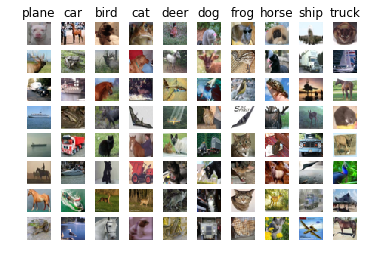

In [10]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?
emmm......看不出来啥东西......

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [11]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [13]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# Your code

# 状态记录
best_val =  -1
best_states = None
results = {}
best_net = None

#  超参数
# learning_rates = [5e-4, 1e-3, 5e-3]
learning_rates = [1e-3, 1e-2, 1e-1, 5e-1, 1]
regularization_strengths = [1e-3, 1e-2, 1e-1, 0.5, 1]
#hidden_size_parms = [50, 75, 100]
iters = 1500

for lr in learning_rates:
    for rs in regularization_strengths:
#        for hid_size in hidden_size_parms:
        # 初始化网络
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        #net = TwoLayerNet(input_size, hidden_size, num_classes)
            
        # train
        states = net.train(X_train_feats, y_train, X_val_feats, y_val,
                            num_iters=iters, batch_size=200,
                            learning_rate=lr, learning_rate_decay=0.95,
                            reg=rs, verbose=True)
            
        # predict
        y_train_pred = net.predict(X_train_feats)
        acc_train = np.mean(y_train == y_train_pred)
        y_val_pred = net.predict(X_val_feats)
        acc_val = np.mean(y_val == y_val_pred)
            
        # record
        results[(lr, rs)] = (acc_train, acc_val)
            
        # record best
        if best_val < acc_val:
            best_states = states
            best_val = acc_val
            best_net = net
                
                
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ("lr ",lr, "reg ", reg, "train accuracy: ", train_accuracy, "val accuracy: ", val_accuracy)


print ("best validation accuracy achieved during cross-validation: ", best_val)



################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 1500: loss 2.302586
cover all samples :: loss:2.302586, train_acc:0.135000, val_acc:0.112000
iteration 100 / 1500: loss 2.302590
iteration 200 / 1500: loss 2.302608
cover all samples :: loss:2.302578, train_acc:0.120000, val_acc:0.113000
iteration 300 / 1500: loss 2.302579
iteration 400 / 1500: loss 2.302560
cover all samples :: loss:2.302568, train_acc:0.105000, val_acc:0.078000
iteration 500 / 1500: loss 2.302596
iteration 600 / 1500: loss 2.302579
iteration 700 / 1500: loss 2.302588
cover all samples :: loss:2.302550, train_acc:0.155000, val_acc:0.078000
iteration 800 / 1500: loss 2.302554
iteration 900 / 1500: loss 2.302596
cover all samples :: loss:2.302484, train_acc:0.135000, val_acc:0.078000
iteration 1000 / 1500: loss 2.302572
iteration 1100 / 1500: loss 2.302569
iteration 1200 / 1500: loss 2.302608
cover all samples :: loss:2.302577, train_acc:0.105000, val_acc:0.079000
iteration 1300 / 1500: loss 2.302551
iteration 1400 / 1500: loss 2.302542
cover all samples :

iteration 1300 / 1500: loss 2.302636
iteration 1400 / 1500: loss 2.302702
cover all samples :: loss:2.302411, train_acc:0.115000, val_acc:0.098000
iteration 0 / 1500: loss 2.303000
cover all samples :: loss:2.303000, train_acc:0.125000, val_acc:0.112000
iteration 100 / 1500: loss 2.302918
iteration 200 / 1500: loss 2.302801
cover all samples :: loss:2.302574, train_acc:0.130000, val_acc:0.078000
iteration 300 / 1500: loss 2.302751
iteration 400 / 1500: loss 2.302663
cover all samples :: loss:2.302666, train_acc:0.125000, val_acc:0.078000
iteration 500 / 1500: loss 2.302970
iteration 600 / 1500: loss 2.302216
iteration 700 / 1500: loss 2.302347
cover all samples :: loss:2.302940, train_acc:0.095000, val_acc:0.078000
iteration 800 / 1500: loss 2.302377
iteration 900 / 1500: loss 2.302680
cover all samples :: loss:2.302233, train_acc:0.125000, val_acc:0.078000
iteration 1000 / 1500: loss 2.302631
iteration 1100 / 1500: loss 2.302939
iteration 1200 / 1500: loss 2.302146
cover all samples :

iteration 1100 / 1500: loss 1.118513
iteration 1200 / 1500: loss 1.092422
cover all samples :: loss:1.187482, train_acc:0.715000, val_acc:0.571000
iteration 1300 / 1500: loss 1.245856
iteration 1400 / 1500: loss 1.184598
cover all samples :: loss:1.185632, train_acc:0.765000, val_acc:0.599000
iteration 0 / 1500: loss 2.302593
cover all samples :: loss:2.302593, train_acc:0.155000, val_acc:0.078000
iteration 100 / 1500: loss 1.702146
iteration 200 / 1500: loss 1.622077
cover all samples :: loss:1.695116, train_acc:0.560000, val_acc:0.479000
iteration 300 / 1500: loss 1.522591
iteration 400 / 1500: loss 1.536535
cover all samples :: loss:1.573333, train_acc:0.620000, val_acc:0.485000
iteration 500 / 1500: loss 1.606072
iteration 600 / 1500: loss 1.498105
iteration 700 / 1500: loss 1.680606
cover all samples :: loss:1.632720, train_acc:0.600000, val_acc:0.501000
iteration 800 / 1500: loss 1.602184
iteration 900 / 1500: loss 1.669159
cover all samples :: loss:1.508401, train_acc:0.625000, 

iteration 800 / 1500: loss 2.307627
iteration 900 / 1500: loss 2.298506
cover all samples :: loss:2.303255, train_acc:0.155000, val_acc:0.102000
iteration 1000 / 1500: loss 2.297496
iteration 1100 / 1500: loss 2.307846
iteration 1200 / 1500: loss 2.309569
cover all samples :: loss:2.302627, train_acc:0.115000, val_acc:0.098000
iteration 1300 / 1500: loss 2.303403
iteration 1400 / 1500: loss 2.298960
cover all samples :: loss:2.304325, train_acc:0.105000, val_acc:0.087000
iteration 0 / 1500: loss 2.303411
cover all samples :: loss:2.303411, train_acc:0.140000, val_acc:0.119000


/home/g214-j/cs231camp/git_cs231_camp_orig/cs231n-camp/assignment/assignment1/cs231n/classifiers/neural_net.py:117: RuntimeWarning: divide by zero encountered in log
  loss = -np.log(scores[np.arange(N), y]).sum()


iteration 100 / 1500: loss inf
iteration 200 / 1500: loss inf
cover all samples :: loss:inf, train_acc:0.040000, val_acc:0.047000
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
cover all samples :: loss:inf, train_acc:0.050000, val_acc:0.048000
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf
iteration 700 / 1500: loss inf
cover all samples :: loss:inf, train_acc:0.025000, val_acc:0.032000
iteration 800 / 1500: loss inf


/home/g214-j/cs231camp/git_cs231_camp_orig/cs231n-camp/assignment/assignment1/cs231n/classifiers/neural_net.py:112: RuntimeWarning: overflow encountered in subtract
  scores -= np.max(scores, axis=1, keepdims=True)
/home/g214-j/cs231camp/git_cs231_camp_orig/cs231n-camp/assignment/assignment1/cs231n/classifiers/neural_net.py:112: RuntimeWarning: invalid value encountered in subtract
  scores -= np.max(scores, axis=1, keepdims=True)
/home/g214-j/cs231camp/git_cs231_camp_orig/cs231n-camp/assignment/assignment1/cs231n/classifiers/neural_net.py:87: RuntimeWarning: invalid value encountered in greater
  s1_relu = (s1 > 0) * s1
/home/g214-j/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/g214-j/cs231camp/git_cs231_camp_orig/cs231n-camp/assignment/assignment1/cs231n/classifiers/neural_net.py:145: RuntimeWarning: invalid value encountered in greater
  ds1 = (s

iteration 900 / 1500: loss nan


/home/g214-j/cs231camp/git_cs231_camp_orig/cs231n-camp/assignment/assignment1/cs231n/classifiers/neural_net.py:270: RuntimeWarning: invalid value encountered in maximum
  output_scores = np.dot(np.maximum(np.dot(X, self.params['W1']) + self.params['b1'], 0), self.params['W2']) + self.params['b2']


cover all samples :: loss:nan, train_acc:0.115000, val_acc:0.087000
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
cover all samples :: loss:nan, train_acc:0.125000, val_acc:0.087000
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
cover all samples :: loss:nan, train_acc:0.100000, val_acc:0.087000
lr  0.001 reg  0.001 train accuracy:  0.10042857142857142 val accuracy:  0.079
lr  0.001 reg  0.01 train accuracy:  0.10042857142857142 val accuracy:  0.079
lr  0.001 reg  0.1 train accuracy:  0.10044897959183674 val accuracy:  0.078
lr  0.001 reg  0.5 train accuracy:  0.10042857142857142 val accuracy:  0.079
lr  0.001 reg  1 train accuracy:  0.10026530612244898 val accuracy:  0.087
lr  0.01 reg  0.001 train accuracy:  0.20214285714285715 val accuracy:  0.189
lr  0.01 reg  0.01 train accuracy:  0.1126530612244898 val accuracy:  0.11
lr  0.01 reg  0.1 train accuracy:  0.10004081632653061 val accuracy:  0.098
lr  0.01 reg  0.5 tra

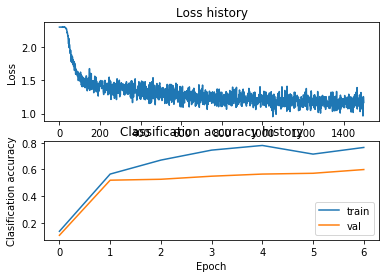

In [14]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(best_states['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_states['train_acc_history'], label='train')
plt.plot(best_states['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

In [15]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.573
